# LM Forest RDD


Trains a linear model forest that can be used to estimate $h_k(x), k=1,...,k$  at $X=x$ in the the conditional linear model $Y = c(x) + h_1(x)W_1 + ... + h_k(x)W_k$, where Y is a (potentially vector-valued) response and W a set of regressors.

In [1]:
# Deleting all current variables
rm(list=ls())

In [2]:
install.packages("rdd")
library(rdd)
library(grf)

Installing package into ‘/home/runner/work/_temp/Library’
(as ‘lib’ is unspecified)



also installing the dependencies ‘backports’, ‘broom’, ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘sp’, ‘minqa’, ‘nloptr’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘lme4’, ‘car’, ‘AER’, ‘Formula’




Loading required package: sandwich



Loading required package: lmtest



Loading required package: zoo




Attaching package: ‘zoo’




The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




Loading required package: AER



Loading required package: car



Loading required package: carData



Loading required package: survival



Loading required package: Formula



This is an example how to use lm_forest.

link [lm_forest](https://grf-labs.github.io/grf/reference/lm_forest.html#references)

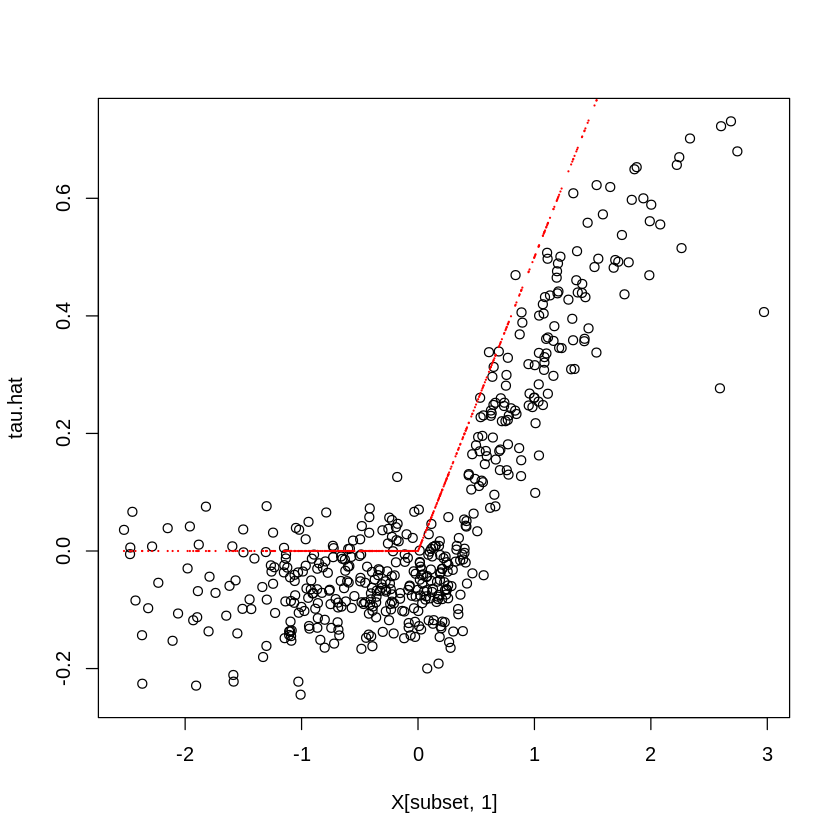

In [3]:
# \donttest{
if (require("rdd", quietly = TRUE)) {
# Train a LM Forest to estimate CATEs in a regression discontinuity design.
# Simulate a simple example with a heterogeneous jump in the CEF.
n <- 2000
p <- 5
X <- matrix(rnorm(n * p), n, p)
Z <- runif(n, -4, 4)
cutoff <- 0
W <- as.numeric(Z >= cutoff)
tau <- pmax(0.5 * X[, 1], 0)
Y <- tau * W  + 1 / (1 + exp(2 * Z)) + 0.2 * rnorm(n)

# Compute the Imbens-Kalyanaraman MSE-optimal bandwidth for a local linear regression.
bandwidth <- IKbandwidth(Z, Y, cutoff)
# Compute kernel weights for a triangular kernel.
sample.weights <- kernelwts(Z, cutoff, bandwidth, "triangular")

# Alternatively, specify bandwith and triangular kernel weights without using the `rdd` package.
# bandwidth <- # user can hand-specify this.
# dist <- abs((Z - cutoff) / bandwidth)
# sample.weights <- (1 - dist) * (dist <= 1) / bandwidth

# Estimate a local linear regression with the running variable Z conditional on covariates X = x:
# Y = c(x) + tau(x) W + b(x) Z.
# Specify gradient.weights = c(1, 0) to target heterogeneity in the RDD coefficient tau(x).
# Also, fit forest on subset with non-zero weights for faster estimation.
subset <- sample.weights > 0
lmf <- lm_forest(X[subset, ], Y[subset], cbind(W, Z)[subset, ],
                 sample.weights = sample.weights[subset], gradient.weights = c(1, 0))
tau.hat <- predict(lmf)$predictions[, 1, ]

# Plot estimated tau(x) vs simulated ground truth.
plot(X[subset, 1], tau.hat)
points(X[subset, 1], tau[subset], col = "red", cex = 0.1)
}#> 
#> Attaching package: ‘zoo’#> The following objects are masked from ‘package:base’:
#> 
#>     as.Date, as.Date.numeric# }

 ## Aplication Causal Forest RDD to following paper titled "Do Voters Affect or Elect Policies: Evidence from the u.s. House."

link [Mixtape](https://mixtape.scunning.com/06-regression_discontinuity)

In [4]:
#First we call the necessary librarieslibrary(tidyverse)
install.packages("librarian")
librarian::shelf(have, estimatr, rockchalk, ggplot2)
library(haven)
library(estimatr)
library(rockchalk)
library(ggplot2)

# Read in data
read_data <- function(df) 
{
  full_path <- paste("https://raw.github.com/scunning1975/mixtape/master/", 
                     df, sep = "")
  df <- read_dta(full_path)
  return(df)
}

data <- read_data("lmb-data.dta")

# Define variables
outcome = "score"
covariates <- c("age", "realincome", "sex", "militaryservice", "secondaryeduc")
running = "lagdemvoteshare"
treatment = "W"

Installing package into ‘/home/runner/work/_temp/Library’
(as ‘lib’ is unspecified)



also installing the dependency ‘BiocManager’





  These packages will be installed:

  'have', 'estimatr', 'rockchalk'

  It may take some time.



also installing the dependencies ‘openxlsx’, ‘RUnit’, ‘kutils’




Warning message in stock(..., lib = lib, update_all = update_all, quiet = quiet, :
“
  These packages failed to install:

  'have'

  Check the spelling and capitalisation of the names.

  Are they Bioconductor packages? If so, please install Bioconductor
  (BiocManager and BiocBase).

  Are they from GitHub? If so, please supply both the GitHub username
  and package name, e.g. DesiQuintans/librarian”


Warning message in librarian::shelf(have, estimatr, rockchalk, ggplot2):
“
  These packages are not installed, so they were not attached:

  'have'

  Did they fail to install? Are they spelled correctly?”


ERROR: Error in library(haven): there is no package called ‘haven’


In [6]:
# Prepare dataset
options(na.action='na.pass')
cutoff <- 0.5
fmla <- formula(paste0("~ 0 + ", paste0(covariates, collapse="+")))
Y <- as.matrix(data[, outcome])
Z <- as.matrix(data[, running])
X <- model.matrix(fmla, data)
W <- as.numeric(Z >= cutoff)
data$W = W

# Compute the Imbens-Kalyanaraman MSE-optimal bandwidth for a local linear regression.
bandwidth <- IKbandwidth(Z, Y, cutoff)
# Compute kernel weights for a triangular kernel.
#sample.weights <- kernelwts(Z, cutoff, bandwidth, "triangular")

# Alternatively, specify bandwith and triangular kernel weights without using the `rdd` package.
# bandwidth <- # user can hand-specify this.
dist <- abs((Z - cutoff) / bandwidth)
sample.weights <- (1 - dist) * (dist <= 1) / bandwidth
sample.weights[is.na(sample.weights)] <- 0

# Estimate a local linear regression with the running variable Z conditional on covariates X = x:
# Y = c(x) + tau(x) W + b(x) Z.
# Specify gradient.weights = c(1, 0) to target heterogeneity in the RDD coefficient tau(x).
# Also, fit forest on subset with non-zero weights for faster estimation.
subset <- sample.weights > 0
#subset <- ! is.na(subset)

lmf <- lm_forest(X[subset, ], Y[subset], cbind(W, Z)[subset, ],
                 sample.weights = sample.weights[subset], gradient.weights = c(1, 0))

tau.hat <- predict(lmf)$predictions[,1,]

The function lm_forest from the package grf allows us to get estimates of the CATE

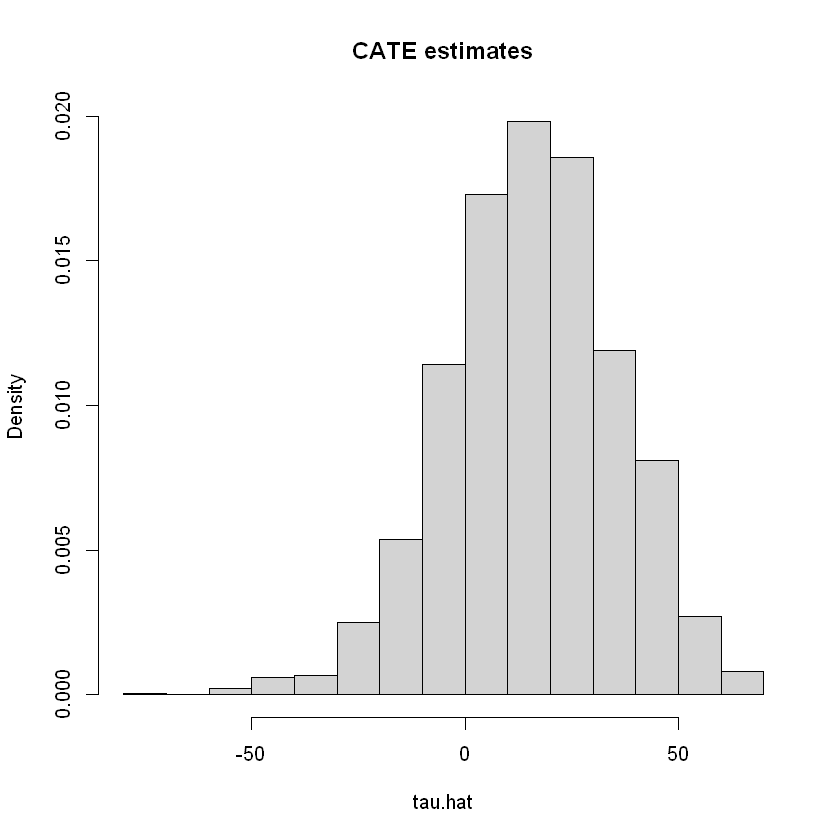

In [7]:
# Do not use this for assessing heterogeneity. See text above.
hist(tau.hat, main="CATE estimates", freq=F)

The grf package also produces a measure of variable importance that indicates how often a variable was used in a tree split. Again, much like the histogram above, this can be a rough diagnostic, but it should not be interpreted as indicating that, for example, variable with low importance is not related to heterogeneity. The reasoning is the same as the one presented in the causal trees section: if two covariates are highly correlated, the trees might split on one covariate but not the other, even though both (or maybe neither) are relevant in the true data-generating process.

In [8]:
var_imp <- c(variable_importance(lmf))
names(var_imp) <- covariates
sorted_var_imp <- sort(var_imp, decreasing = TRUE)
sorted_var_imp[1:5]  # showing only first few

age      realincome militaryservice   secondaryeduc             sex 
     0.59638882      0.30229521      0.04765092      0.04480421      0.00886083

## Data-driven subgroups

In [9]:
# Valid randomized data and observational data with unconfoundedness+overlap.
# Note: read the comments below carefully. 
# In randomized settings, do not estimate forest.e and e.hat; use known assignment probs.

# Prepare dataset
#fmla <- formula(paste0("~ 0 + ", paste0(covariates, collapse="+")))
#X <- model.matrix(fmla, data)
#W <- data[,treatment]
#Y <- data[,outcome]

# Number of rankings that the predictions will be ranking on 
# (e.g., 2 for above/below median estimated CATE, 5 for estimated CATE quintiles, etc.)
n = nrow(X[subset, ])

num.rankings <- 5  

# Prepare for data.splitting
# Assign a fold number to each observation.
# The argument 'clusters' in the next step will mimick K-fold cross-fitting.
num.folds <- 10
folds <- sort(seq(n) %% num.folds) + 1
# Comment or uncomment depending on your setting.
# Observational setting with unconfoundedness+overlap (unknown assignment probs):
# forest <- causal_forest(X, Y, W, clusters = folds)
# Randomized settings with fixed and known probabilities (here: 0.5).
#forest <- causal_forest(X, Y, W, W.hat=.5, clusters = folds)

lmf <- lm_forest(X[subset, ], Y[subset], cbind(W, Z)[subset, ], clusters = folds,
                 sample.weights = sample.weights[subset], gradient.weights = c(1, 0))

# Rank observations *within each fold* into quintiles according to their CATE predictions.
ranking <- rep(NA, n)
for (fold in seq(num.folds)) {
  tau.hat.quantiles <- quantile(tau.hat[folds == fold], probs = seq(0, 1, by=1/num.rankings))
  ranking[folds == fold] <- cut(tau.hat[folds == fold], tau.hat.quantiles, include.lowest=TRUE,labels=seq(num.rankings))
}

The next snippet computes the average treatment effect within each group defined above, i.e., $\mathbf{E}[Y_i(1) - Y_i(0)|G_i = g]$. This can done in two ways. First, by computing a simple difference-in-means estimate of the ATE based on observations within each group. This is valid only in randomized settings.

In [10]:
#Since the ranking vector was created from tau.hat, which has rows equal to nrows of X[subset,] ...
# .. we need data with nrows iqual to X[subset] rows
newdata = data[subset,]

In [11]:
# Average difference-in-means within each ranking

# Formula y ~ 0 + ranking + ranking:w
fmla <- paste0(outcome, " ~ 0 + ranking + ranking:", treatment)
ols.ate <- lm(fmla, data=transform(newdata, ranking=factor(ranking)))
ols.ate <- coeftest(ols.ate, vcov=vcovHC(ols.ate, type='HC2'))
interact <- which(grepl(":", rownames(ols.ate)))
ols.ate <- data.frame("ols", paste0("Q", seq(num.rankings)), ols.ate[interact, 1:2])
rownames(ols.ate) <- NULL # just for display
colnames(ols.ate) <- c("method", "ranking", "estimate", "std.err")
ols.ate

method,ranking,estimate,std.err
<chr>,<chr>,<dbl>,<dbl>
ols,Q1,16.86639,1.741709
ols,Q2,25.38157,1.649339
ols,Q3,34.00134,1.530182
ols,Q4,36.68675,1.556861
ols,Q5,44.62000,1.363089


The code below plots the estimates.

In [12]:
# Concatenate the two results.
res <- rbind(ols.ate)

# Plotting the point estimate of average treatment effect 
# and 95% confidence intervals around it.
ggplot(res) +
  aes(x = ranking, y = estimate, group=method, color=method) + 
  geom_point(position=position_dodge(0.2)) +
  geom_errorbar(aes(ymin=estimate-2*std.err, ymax=estimate+2*std.err), width=.2, position=position_dodge(0.2)) +
  ylab("") + xlab("") +
  ggtitle("Average CATE within each ranking (as defined by predicted CATE)") +
  theme_minimal() +
  theme(legend.position="bottom", legend.title = element_blank())

ERROR: Error in ggplot(res): no se pudo encontrar la función "ggplot"


Next, we can test e.g., if the prediction for groups 2, 3, etc. are larger than the one in the first group. Here’s how to do it based on a difference-in-means estimator. Note the Romano-Wolf multiple-hypothesis testing correction.

In [252]:
# Auxiliary function to computes adjusted p-values 
# following the Romano-Wolf method.
# For a reference, see http://ftp.iza.org/dp12845.pdf page 8
#  t.orig: vector of t-statistics from original model
#  t.boot: matrix of t-statistics from bootstrapped models
romano_wolf_correction <- function(t.orig, t.boot) {
  abs.t.orig <- abs(t.orig)
  abs.t.boot <- abs(t.boot)
  abs.t.sorted <- sort(abs.t.orig, decreasing = TRUE)

  max.order <- order(abs.t.orig, decreasing = TRUE)
  rev.order <- order(max.order)

  M <- nrow(t.boot)
  S <- ncol(t.boot)

  p.adj <- rep(0, S)
  p.adj[1] <- mean(apply(abs.t.boot, 1, max) > abs.t.sorted[1])
  for (s in seq(2, S)) {
    cur.index <- max.order[s:S]
    p.init <- mean(apply(abs.t.boot[, cur.index, drop=FALSE], 1, max) > abs.t.sorted[s])
    p.adj[s] <- max(p.init, p.adj[s-1])
  }
  p.adj[rev.order]
}

# Computes adjusted p-values for linear regression (lm) models.
#    model: object of lm class (i.e., a linear reg model)
#    indices: vector of integers for the coefficients that will be tested
#    cov.type: type of standard error (to be passed to sandwich::vcovHC)
#    num.boot: number of null bootstrap samples. Increase to stabilize across runs.
# Note: results are probabilitistic and may change slightly at every run. 
#
# Adapted from the p_adjust from from the hdm package, written by Philipp Bach.
# https://github.com/PhilippBach/hdm_prev/blob/master/R/p_adjust.R
summary_rw_lm <- function(model, indices=NULL, cov.type="HC2", num.boot=10000) {

  if (is.null(indices)) {
    indices <- 1:nrow(coef(summary(model)))
  }
  # Grab the original t values.
  summary <- coef(summary(model))[indices,,drop=FALSE]
  t.orig <- summary[, "t value"]

  # Null resampling.
  # This is a trick to speed up bootstrapping linear models.
  # Here, we don't really need to re-fit linear regressions, which would be a bit slow.
  # We know that betahat ~ N(beta, Sigma), and we have an estimate Sigmahat.
  # So we can approximate "null t-values" by
  #  - Draw beta.boot ~ N(0, Sigma-hat) --- note the 0 here, this is what makes it a *null* t-value.
  #  - Compute t.boot = beta.boot / sqrt(diag(Sigma.hat))
  Sigma.hat <- vcovHC(model, type=cov.type)[indices, indices]
  se.orig <- sqrt(diag(Sigma.hat))
  num.coef <- length(se.orig)
  beta.boot <- mvrnorm(n=num.boot, mu=rep(0, num.coef), Sigma=Sigma.hat)
  t.boot <- sweep(beta.boot, 2, se.orig, "/")
  p.adj <- romano_wolf_correction(t.orig, t.boot)

  result <- cbind(summary[,c(1,2,4),drop=F], p.adj)
  colnames(result) <- c('Estimate', 'Std. Error', 'Orig. p-value', 'Adj. p-value')
  result
}

In [253]:
# y ~ ranking + w + ranking:w
fmla <- paste0(outcome, "~ ranking + ", treatment, " + ranking:", treatment) 
ols <- lm(fmla, data=transform(newdata, ranking=factor(ranking)))
interact <- which(sapply(names(coef(ols)), function(x) grepl(":", x)))
res <- summary_rw_lm(ols, indices=interact)
rownames(res) <- paste("Rank", 2:num.rankings, "- Rank 1") # just for display
res

,Estimate,Std. Error,Orig. p-value,Adj. p-value
Rank 2 - Rank 1,6.075643,1.569542,1.089134e-04,3e-04
Rank 3 - Rank 1,11.959623,1.565654,2.340203e-14,0e+00
Rank 4 - Rank 1,12.196804,1.568579,8.041885e-15,0e+00
Rank 5 - Rank 1,15.265177,1.567347,2.421065e-22,0e+00


Finally, we can also check if different groups have different average covariate levels across rankings.

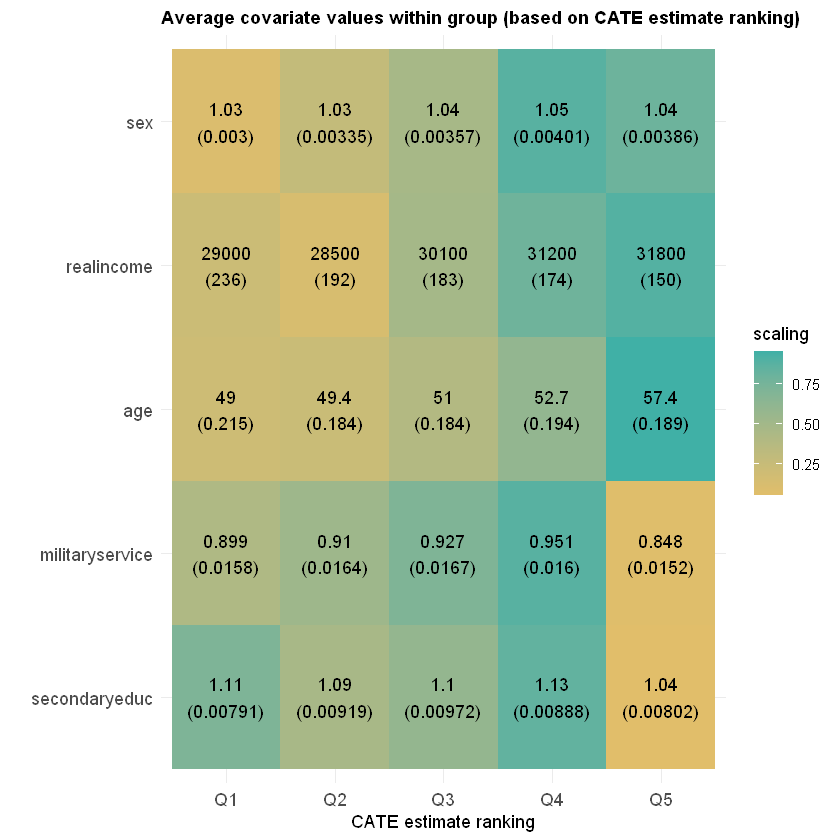

In [254]:
df <- mapply(function(covariate) {
      # Looping over covariate names
      # Compute average covariate value per ranking (with correct standard errors)
      fmla <- formula(paste0(covariate, "~ 0 + ranking"))
      ols <- lm(fmla, data=transform(newdata, ranking=factor(ranking)), na.action=na.exclude)
      ols.res <- coeftest(ols, vcov=vcovHC(ols, "HC2"))
    
      # Retrieve results
      avg <- ols.res[,1]
      stderr <- ols.res[,2]
      
      # Tally up results
      data.frame(covariate, avg, stderr, ranking=paste0("Q", seq(num.rankings)), 
                 # Used for coloring
                 scaling=pnorm((avg - mean(avg))/sd(avg)), 
                 # We will order based on how much variation is 'explain' by the averages
                 # relative to the total variation of the covariate in the data
                 variation=sd(avg) / sd(as.numeric(unlist(newdata[,covariate])), na.rm=TRUE),
                 # String to print in each cell in heatmap below
                 labels=paste0(signif(avg, 3), "\n", "(", signif(stderr, 3), ")"))
}, covariates, SIMPLIFY = FALSE)
df <- do.call(rbind, df)

# a small optional trick to ensure heatmap will be in decreasing order of 'variation'
df$covariate <- reorder(df$covariate, order(df$variation))

# plot heatmap
ggplot(df) +
    aes(ranking, covariate) +
    geom_tile(aes(fill = scaling)) + 
    geom_text(aes(label = labels)) +
    scale_fill_gradient(low = "#E1BE6A", high = "#40B0A6") +
    ggtitle(paste0("Average covariate values within group (based on CATE estimate ranking)")) +
    theme_minimal() + 
    ylab("") + xlab("CATE estimate ranking") +
    theme(plot.title = element_text(size = 11, face = "bold"),
          axis.text=element_text(size=11)) 

#### Partial dependence

It may also be interesting to examine how our CATE estimates behave when we change a single covariate, while keeping all the other covariates at a some fixed value. In the plot below we evaluate a variable of interest across quantiles, while keeping all other covariates at their median. 

It is important to recognize that by keeping some variables at their median we may be evaluating the CATE at $x$ values in regions where there are few or no data points. Also, it may be the case that varying some particular variable while keeping others fixed may just not be very interesting.

In what follows we'll again use `lm_forest` predictions, along with their variance estimates (set `estimate.variances=TRUE` when predicting to we get estimates of the asymptotic variance of the prediction for each point). Since `grf` predictions are asymptotically normal, we can construct 95\% confidence intervals in the usual manner (i.e., $\hat{\tau}(x) \pm 1.96\sqrt{\widehat{\text{Var}}(\hat{\tau}(x))}$).


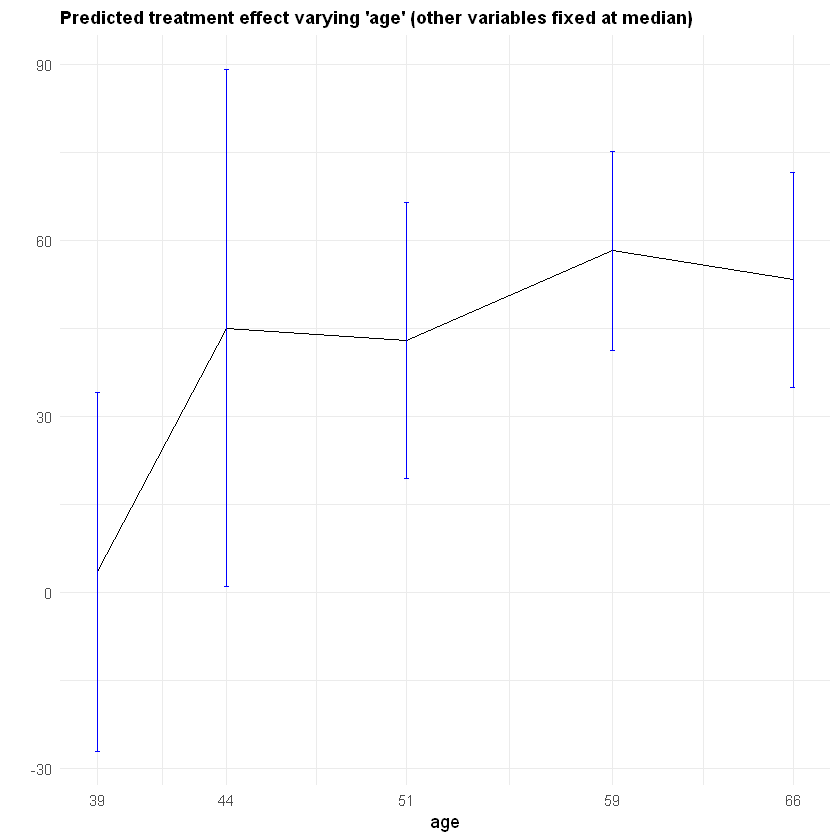

In [255]:
selected.covariate <- "age"
other.covariates <- covariates[which(covariates != selected.covariate)]

# Fitting a forest 
# (commented for convenience; no need re-fit if already fitted above)
fmla <- formula(paste0("~ 0 + ", paste0(covariates, collapse="+")))
# Note: For smaller confidence intervals, set num.trees ~ sample size
# X <- model.matrix(fmla, data)
# W <- data[,treatment]
# Y <- data[,outcome]
# forest.tau <- causal_forest(X, Y, W, W.hat=.5)  # few trees for speed here

# Compute a grid of values appropriate for the selected covariate
#grid.size <- 7 
#covariate.grid <- seq(min(newdata[,selected.covariate]), max(newdata[,selected.covariate]), length.out=grid.size)

# Other options for constructing a grid:
# For a binary variable, simply use 0 and 1
# grid.size <- 2
# covariate.grid <- c(0, 1)  

# For a continuous variable, select appropriate percentiles
percentiles <- c(.1, .25, .5, .75, .9)
grid.size <- length(percentiles)
covariate.grid <- quantile(newdata[,selected.covariate], probs=percentiles, na.rm= TRUE)

# Take median of other covariates 
medians <- apply(newdata[, other.covariates, F], 2, median, na.rm=TRUE)

# Construct a dataset
data.grid <- data.frame(sapply(medians, function(x) rep(x, grid.size)), covariate.grid)
colnames(data.grid) <- c(other.covariates, selected.covariate)

# Expand the data
X.grid <- model.matrix(fmla, data.grid)

# Point predictions of the CATE and standard errors 
forest.pred <- predict(lmf, newdata = X.grid, estimate.variance=TRUE)
tau.hat <- forest.pred$predictions
tau.hat.se <- sqrt(forest.pred$variance.estimates)

# Plot predictions for each group and 95% confidence intervals around them.
data.pred <- transform(data.grid, tau.hat=tau.hat, ci.low = tau.hat[,,1] - 2*tau.hat.se, ci.high = tau.hat[,,1] + 2*tau.hat.se)
ggplot(data.pred) +
  geom_line(aes_string(x=selected.covariate, y="tau.hat.W.Y.1", group = 1), color="black") +
  geom_errorbar(aes_string(x=selected.covariate, ymin="ci.low.W", ymax="ci.high.W", width=.2), color="blue") +
   ylab("")  +
  ggtitle(paste0("Predicted treatment effect varying '", selected.covariate, "' (other variables fixed at median)")) +
  scale_x_continuous("age", breaks=covariate.grid, labels=signif(covariate.grid, 2)) +
  theme_minimal() +
  theme(plot.title = element_text(size = 11, face = "bold"))

## References

Athey, Susan, Julie Tibshirani, and Stefan Wager. "Generalized Random Forests". Annals of Statistics, 47(2), 2019.

Zeileis, Achim, Torsten Hothorn, and Kurt Hornik. "Model-based Recursive Partitioning." Journal of Computational and Graphical Statistics 17(2), 2008.